# **14장 베스트 모델 만들기**

포르투갈 서북쪽의 대서양을 맞닿고 위치한 비뉴 베르드 지방에서 만들어진 와인을 측정한 데이터입니다. 레드와인 샘플 1599개의 등급, 맛, 산도를 분석하고 화이트와인 샘플 4898개를 마찬가지로 분석해 데이터를 만듭니다.


In [ ]:
# 데이터 입력
from google.colab import files
uploaded = files.upload()
my_data = 'wine.csv'

!pip install -q tensorflow-gpu==1.15.0
%tensorflow_version 1.x
import tensorflow as tf
import pandas as pd
import numpy
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping #오버피팅과 밀접한 관계가 있습니다

# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.compat.v1.set_random_seed(3)

# 데이터 적용
df_pre = pd.read_csv(my_data, header=None)
df = df_pre.sample(frac=1)

Saving wine.csv to wine (2).csv
TensorFlow 1.x selected.


Using TensorFlow backend.


sample() 함수는 원본 데이터에서 정해진 비율만큼 랜덤으로 뽑아오는 함수입니다. frac=1이라고 지정하면 원본 데이터의 100%를 불러오라는 의미입니다. frac-0.5로 지정하면 50%만 랜덤으로 불러옵니다.

In [ ]:
dataset = df.values
X = dataset[:,0:12]
Y = dataset[:,12]

와인 데이터는 12개의 feature로 구성되어 있습니다.

0: 주석산 농도

1: 아세트산 농도

2: 구연산 농도

3: 잔류 당분 노도

4: 염화나트륨 농도

5: 유리 아황산 농도

6: 총 아황산 농도

7: 밀도

8: pH

9: 황산칼륨 농도

10: 알코올 도수

11: 와인의 맛(0-10등급)

12: class(1: 레드와인, 0: 화이트와인)

In [ ]:
# 모델 설정
model = Sequential()
model.add(Dense(30,  input_dim=12, activation='relu')) #input node 12개, hidden node 30개
model.add(Dense(12, activation='relu')) #hidden node 12개
model.add(Dense(8, activation='relu')) #hidden node 8개
model.add(Dense(1, activation='sigmoid')) #0과 1이므로 softmax 아닌 sigmoid를 이용합니다

#모델 컴파일
model.compile(loss='binary_crossentropy', #0 아니면 1이니까 binary_crossentropy
           optimizer='adam',
           metrics=['accuracy'])

# 모델 실행
model.fit(X, Y, epochs=200, batch_size=200)

# 결과 출력
print("\n Accuracy: %.4f" % (model.evaluate(X, Y)[1]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/200
6497/6497 [==============================] - 0s 30us/step - loss: 3.6440 - accuracy: 0.2461
Epoch 2/200
6497/6497 [==============================] - 0s 10us/step - loss: 0.4343 - accuracy: 0.8088
Epoch 3/200
6497/6497 [==============================] - 0s 7us/step - loss: 0.2413 - accuracy: 0.9263
Epoch 4/200
6497/6497 [==============================] - 0s 10us/step - loss: 0.2139 - accuracy: 0.9301
Epoch 5/200
6497/6497 [==============================] - 0s 11us/step - loss: 0.2037 - accuracy: 0.9307
Epoch 6/200
6497/6497 [==============================] - 0s 9us/step - loss: 0.1976 - accuracy: 0.9315
Epoch 7/200
6497/6497 [==============================] - 0s 8us/step - loss: 0.1930 - accuracy: 0.9324
Epoch 8/200
6497/6497 [==============================] - 0s 9us/step - loss: 0.1889 - accuracy: 0.9

데이터 수가 많아 퍼포먼스가 좋습니다. Accuracy가 0.9889로 나옵니다.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                372       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 875
Trainable params: 875
Non-trainable params: 0
_________________________________________________________________


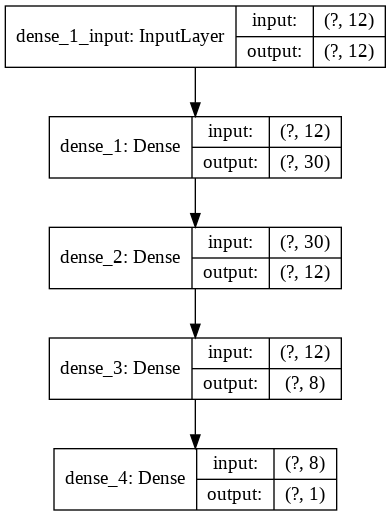

In [ ]:
from tensorflow import keras

model.summary()
keras.utils.plot_model(model, "myModel.png", show_shapes=True)

#**Wine_Checkpoint**

이제 모델을 저장하기 위해 케라스의 콜백 함수 중 ModelCheckpoint() 함수를 불러옵니다.

In [ ]:
import os

# 모델 저장 폴더 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
   os.mkdir(MODEL_DIR)

# 모델 저장 조건 설정
modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)

테스트 오차는 케라스 내부에서 val_loss로 기록됩니다. 학습 정확도는 accuracy, 테스트셋 정확도는 val_accuracy, 학습셋 오차는 loss로 각각 기록됩니다.

모델을 그냥 저장하는 것이 아니라 에포트(epoch)마다 모델의 정확도를 함께 기록하면서 저장해봅시다. 이제 모델을 학습할 때마다 위에서 정한 checkpointer의 값을 받아 지정된 곳에 모델을 저장합니다.

저장된 파일의 이름이 곧 에포크 수와 이 때의 테스트셋 오차값입니다. 이때 ModelCheckpoint() 함수에 모델이 앞서 저장한 모델보다 나아졌을 때만 저장하게끔 하려면 save_best_only값을 True로 저장합니다.

In [ ]:
# 모델 실행 및 저장
model.fit(X, Y, validation_split=0.2, epochs=200, batch_size=200, verbose=0, callbacks=[checkpointer]) 
#checkpointer를 써서 val_loss를 기록합니다.


Epoch 00001: val_loss improved from inf to 0.04911, saving model to ./model/01-0.0491.hdf5

Epoch 00002: val_loss did not improve from 0.04911

Epoch 00003: val_loss did not improve from 0.04911

Epoch 00004: val_loss did not improve from 0.04911

Epoch 00005: val_loss improved from 0.04911 to 0.04657, saving model to ./model/05-0.0466.hdf5

Epoch 00006: val_loss improved from 0.04657 to 0.04656, saving model to ./model/06-0.0466.hdf5

Epoch 00007: val_loss did not improve from 0.04656

Epoch 00008: val_loss improved from 0.04656 to 0.04625, saving model to ./model/08-0.0463.hdf5

Epoch 00009: val_loss did not improve from 0.04625

Epoch 00010: val_loss did not improve from 0.04625

Epoch 00011: val_loss did not improve from 0.04625

Epoch 00012: val_loss did not improve from 0.04625

Epoch 00013: val_loss did not improve from 0.04625

Epoch 00014: val_loss did not improve from 0.04625

Epoch 00015: val_loss did not improve from 0.04625

Epoch 00016: val_loss did not improve from 0.04